In [31]:
import numpy as np, matplotlib.pyplot as plt
from sympy import Symbol, Matrix, solve

# Anisotropic finite viscoelasticity
##### Source: Liu et al. 2019

In [161]:
def eval_liu(F, Cvminv, I4v, dt):
    #========================
    # Material parameters (Table 2)
    beta1 = 0 
    beta2 = 1.4
    tau1  = 1
    tau2  = 0.695
    kappa = 1e6       # [MPa]
    c     = 0.113     # [MPa]
    k1    = 0.18      # [MPa]
    k2    = 34.16
    a0 = np.array([1,0,0])
    #========================
    
    #========================
    # Material parameters (Table 1)
    beta1 = 1
    beta2 = 1
    tau1  = 1
    tau2  = 1
    kappa = 1e6       # [MPa]
    c     = 0.877     # [MPa]
    k1    = 0.154     # [MPa]
    k2    = 34.157
    a0 = np.array([1,0,0])
    #========================
    
    C = np.dot(F,F.transpose())
    Cinv = np.linalg.inv(C)
    J = np.linalg.det(F)
    Cbar = J**(-2/3)*C
    Cbarinv = np.linalg.inv(Cbar)
    I1 = C[0,0] + C[1,1] + C[2,2]
    
    #================= Algorithm 1: Evolution equation of the isotropic viscous part =================#
    #Eq. (47) turns into a 3rd order polynomial in alpha
    A = Cvminv
    B = Cinv
    aux1 =    B[0,0]*B[1,2]*B[2,2] -   B[0,0]*B[1,2]**2     -   B[0,1]**2*B[2,2]     + 2*B[0,1]*B[0,2]*B[1,2] -   B[0,2]**2*B[1,1]
    aux2 =    A[0,0]*B[1,1]*B[2,2] -   A[0,0]*B[1,2]**2     - 2*A[0,1]*B[0,1]*B[2,2] + 2*A[0,1]*B[0,2]*B[1,2] + 2*A[0,2]*B[0,1]*B[1,2] - \
            2*A[0,2]*B[0,2]*B[1,1] +   A[1,1]*B[0,0]*B[2,2] -   A[1,1]*B[0,2]**2     - 2*A[1,2]*B[0,0]*B[1,2] + 2*A[1,2]*B[0,1]*B[0,2] + \
              A[2,2]*B[0,0]*B[1,1] -   A[2,2]*B[0,1]**2
    aux3 =    A[0,0]*A[1,1]*B[2,2] - 2*A[0,0]*A[1,2]*B[1,2] +   A[0,0]*A[2,2]*B[1,1] -   A[0,1]**2*B[2,2]     + 2*A[0,1]*A[0,2]*B[1,2] + \
            2*A[0,1]*A[1,2]*B[1,2] - 2*A[0,1]*A[2,2]*B[0,1] -   A[0,2]**2*B[1,1]     - 2*A[0,2]*A[1,1]*B[0,2] + 2*A[0,2]*A[1,2]*B[0,1] + \
              A[1,1]*A[2,2]*B[0,0] -   A[1,2]**2*B[0,0]
    aux4 =    A[0,0]*A[1,1]*A[2,2] -   A[0,0]*A[1,2]**2     -   A[0,1]**2*A[2,2]     + 2*A[0,1]*A[1,2]*A[1,2] -   A[0,2]**2*A[1,1]
    aux1 = aux1*dt**3
    aux2 = aux2*dt**2
    aux3 = aux3*dt
    aux4 = aux4 - (tau1+dt)**3/tau1**3
    alpha = np.roots([aux1, aux2, aux3, aux4])
    
    # !!TODO: pick the right alpha from the 3 solutions. So far I am just picking the first real, non-negative solution
    
    alpha = alpha[np.isreal(alpha)]
    alpha = alpha[alpha>=0]
    alpha = alpha[0]
    
    Cvminvnew = tau1/(tau1+dt)*(Cvminv + alpha*dt*Cinv) # (47)
    
    Psiebar = beta1*c # (14)
    
    Svisiso = 2*Psiebar*J**(-2/3)*(Cvminvnew - 1/3*(np.tensordot(C, Cvminvnew))*Cinv) #(19)
    #=================================================================================================#
    
    #================ Algorithm 2: Evolution equation of the anisotropic viscous part ================#

    I4ebar = np.tensordot(Cbar,np.outer(a0,a0))/I4v #(50) #Note that I4v = I4vbar since the viscous part is isochoric
    
    #Solve (49) with NR
    res = 1
    iter = 0
    I4ebarnew = I4ebar # Initial guess for I4ebarnew
    #print('---')
    while np.abs(res)>1.-6 and iter<10:
        eps = 1.-9
        res  = I4ebarnew     + (dt/tau2*I4ebarnew*(I4ebarnew    -1))/( I4ebarnew     *(1+2*k2*(I4ebarnew    -1)**2) + I4ebarnew    -1) - I4ebar
        resp = I4ebarnew+eps + (dt/tau2*I4ebarnew*(I4ebarnew+eps-1))/((I4ebarnew+eps)*(1+2*k2*(I4ebarnew+eps-1)**2) + I4ebarnew+eps-1) - I4ebar
        resm = I4ebarnew-eps + (dt/tau2*I4ebarnew*(I4ebarnew-eps-1))/((I4ebarnew-eps)*(1+2*k2*(I4ebarnew-eps-1)**2) + I4ebarnew-eps-1) - I4ebar
        dres = (resp-resm)/2/eps #dres/dI4ebarnew
        I4ebarnew = I4ebarnew - res/dres
        iter+= 1
        #print(res)
    I4bar = np.tensordot(Cbar,np.outer(a0,a0)) #(9)
    I4vnew = I4bar/I4ebarnew #(13)
    
    Svisani = 2*beta2*k1*(I4ebarnew-1)*np.exp(k2*(I4ebarnew-1)**2)*J**(-2/3)*I4ebarnew*(np.outer(a0,a0)/I4bar - 1/3*Cbarinv) # (21)
    #=================================================================================================#
    
    Psi1bar = c # (14)
    Psi4bar = k1*(I4bar-1)*(np.exp(k2*(I4bar-1)**2)-1) # (14)
    Seqiso = 2*Psi1bar*J**(-2/3)*(np.eye(3)-1/3*I1*Cinv) # (18)
    Seqani = 2*Psi4bar*J**(-2/3)*I4bar*(np.outer(a0,a0)/I4bar - 1/3*Cbarinv) # (20)
    Spen = kappa*(J**2-J)*Cinv # (22)
    
    S = Seqiso + Svisiso + Seqani + Svisani + Spen # (15)
    sigma = 1/J*np.dot(F,np.dot(S,F.transpose()))
    
    return sigma, Cvminvnew, I4vnew

In [156]:
# uniaxial tension 
# epsilon_x(t)
# sigma_y, sigma_z
nsteps = 200
dt = 0.1
F_vec = np.zeros((nsteps,3,3))
Cvminv_vec = np.zeros((nsteps,3,3))
sigma_vec = np.zeros((nsteps,3,3))
epsilon_xv_vec = np.zeros((nsteps))
lamb_e_vec = np.zeros((nsteps,3))
# initial condition for viscous strains 
epsilon_v = np.zeros((6))
Cvminv = np.eye(3)
I4v = 1
for i in range(nsteps):
    if i<10:
        epsilon_x = i/nsteps*2 + 1e-6
    else:
        epsilon_x = 0.1
    
    sigma_y = 0
    sigma_z = 0
    normres = 1
    iter=0
    itermax = 20
    epsilon_y = 0
    epsilon_z = 0
    eta = 10
    while normres>1e-6 and iter<itermax:
        # guess for F
        F = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z]])
        sigma, Cvminvnew, I4vnew = eval_liu(F, Cvminv, I4v, dt)
        res = np.array([sigma[1,1]-sigma_y, sigma[2,2]-sigma_z])
        
        # calculate dres with NR 
        F_py = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y+1e-6, 0], [0, 0, 1+epsilon_z]])
        sigma_py, aux, aux2 = eval_liu(F_py, Cvminv, I4v, dt)
        F_pz = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z+1e-6]])
        sigma_pz, aux, aux2 = eval_liu(F_pz, Cvminv, I4v, dt)
        dres = np.array([[(sigma_py[1,1]-sigma[1,1])/1e-6,(sigma_py[2,2]-sigma[2,2])/1e-6],\
                        [(sigma_pz[1,1]-sigma[1,1])/1e-6,(sigma_pz[2,2]-sigma[2,2])/1e-6]])
        deps = np.linalg.solve(dres,-res)
        epsilon_y += deps[0]
        epsilon_z += deps[1]
        normres = np.linalg.norm(res)
        iter+=1 

    # update the internal variable at end of iterations 
    Cvminv = Cvminvnew
    I4v = I4vnew
    F_vec[i] = F
    sigma_vec[i] = sigma
    Cvminv_vec[i] = Cvminv

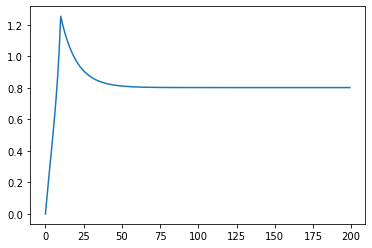

In [157]:
plt.plot(sigma_vec[:,0,0])

In [168]:
# uniaxial tension in plane stress
# epsilon_x(t)
# sigma_y, sigma_z
nsteps = 200
dt = 0.1
F_vec = np.zeros((nsteps,3,3))
Cvminv_vec = np.zeros((nsteps,3,3))
sigma_vec = np.zeros((nsteps,3,3))
epsilon_xv_vec = np.zeros((nsteps))
lamb_e_vec = np.zeros((nsteps,3))
# initial condition for viscous strains 
epsilon_v = np.zeros((6))
Cvminv = np.eye(3)
I4v = 1
for i in range(nsteps):
    if i<10:
        epsilon_x = i/nsteps*2 + 1e-6
        epsilon_y = i/nsteps*2 + 1e-6
    else:
        epsilon_x = 0.1
        epsilon_y = 0.1
    
    sigma_y = 0
    sigma_z = 0
    normres = 1
    iter=0
    itermax = 20
    #epsilon_y = 0
    epsilon_z = 0
    eta = 10
    while normres>1e-6 and iter<itermax:
        # guess for F
        F = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z]])
        sigma, Cvminvnew, I4vnew = eval_liu(F, Cvminv, I4v, dt)
        res = sigma[2,2]-sigma_z
        
        # calculate dres with NR 
        F_pz = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z+1e-6]])
        sigma_pz, aux, aux2 = eval_liu(F_pz, Cvminv, I4v, dt)
        dres = (sigma_pz[2,2]-sigma[2,2])/1e-6
        
        deps = -res/dres
        epsilon_z += deps
        normres = np.linalg.norm(res)
        iter+=1 

    # update the internal variable at end of iterations 
    Cvminv = Cvminvnew
    I4v = I4vnew
    F_vec[i] = F
    sigma_vec[i] = sigma
    Cvminv_vec[i] = Cvminv

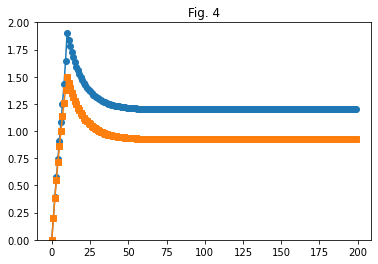

In [175]:
plt.plot(sigma_vec[:,0,0],'o-')
plt.plot(sigma_vec[:,1,1],'s-')
plt.ylim(0,2)
plt.title('Fig. 4')
pass